In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score 
from sklearn.metrics import precision_recall_fscore_support, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

import functools

import h5py

### Environmental vars

In [2]:
P_THRESHOLD=0.5

In [3]:
DATADIR = os.getenv('DATADIR')

### get some data about taxons/content

In [4]:
labelled_level2 = pd.read_csv(
    os.path.join(DATADIR, 'labelled_level2.csv.gz'),
    dtype=object,
    compression='gzip'
)

In [5]:
# Create World taxon in case any items not identified 
# through doc type in clean_content are still present
labelled_level2.loc[labelled_level2['level1taxon'] == 'World', 'level2taxon'] = 'world_level1'

In [6]:
# creating categorical variable for level2taxons from values
labelled_level2['level2taxon'] = labelled_level2['level2taxon'].astype('category')

# Add 1 because of zero-indexing to get 1-number of level2taxons as numerical targets
labelled_level2['level2taxon_code'] = labelled_level2.level2taxon.astype('category').cat.codes + 1

# create dictionary of taxon category code to string label for use in model evaluation
labels_index = dict(zip((labelled_level2['level2taxon_code']),
                        labelled_level2['level2taxon']))

In [7]:
labelled_level2.content_id.nunique()

129611

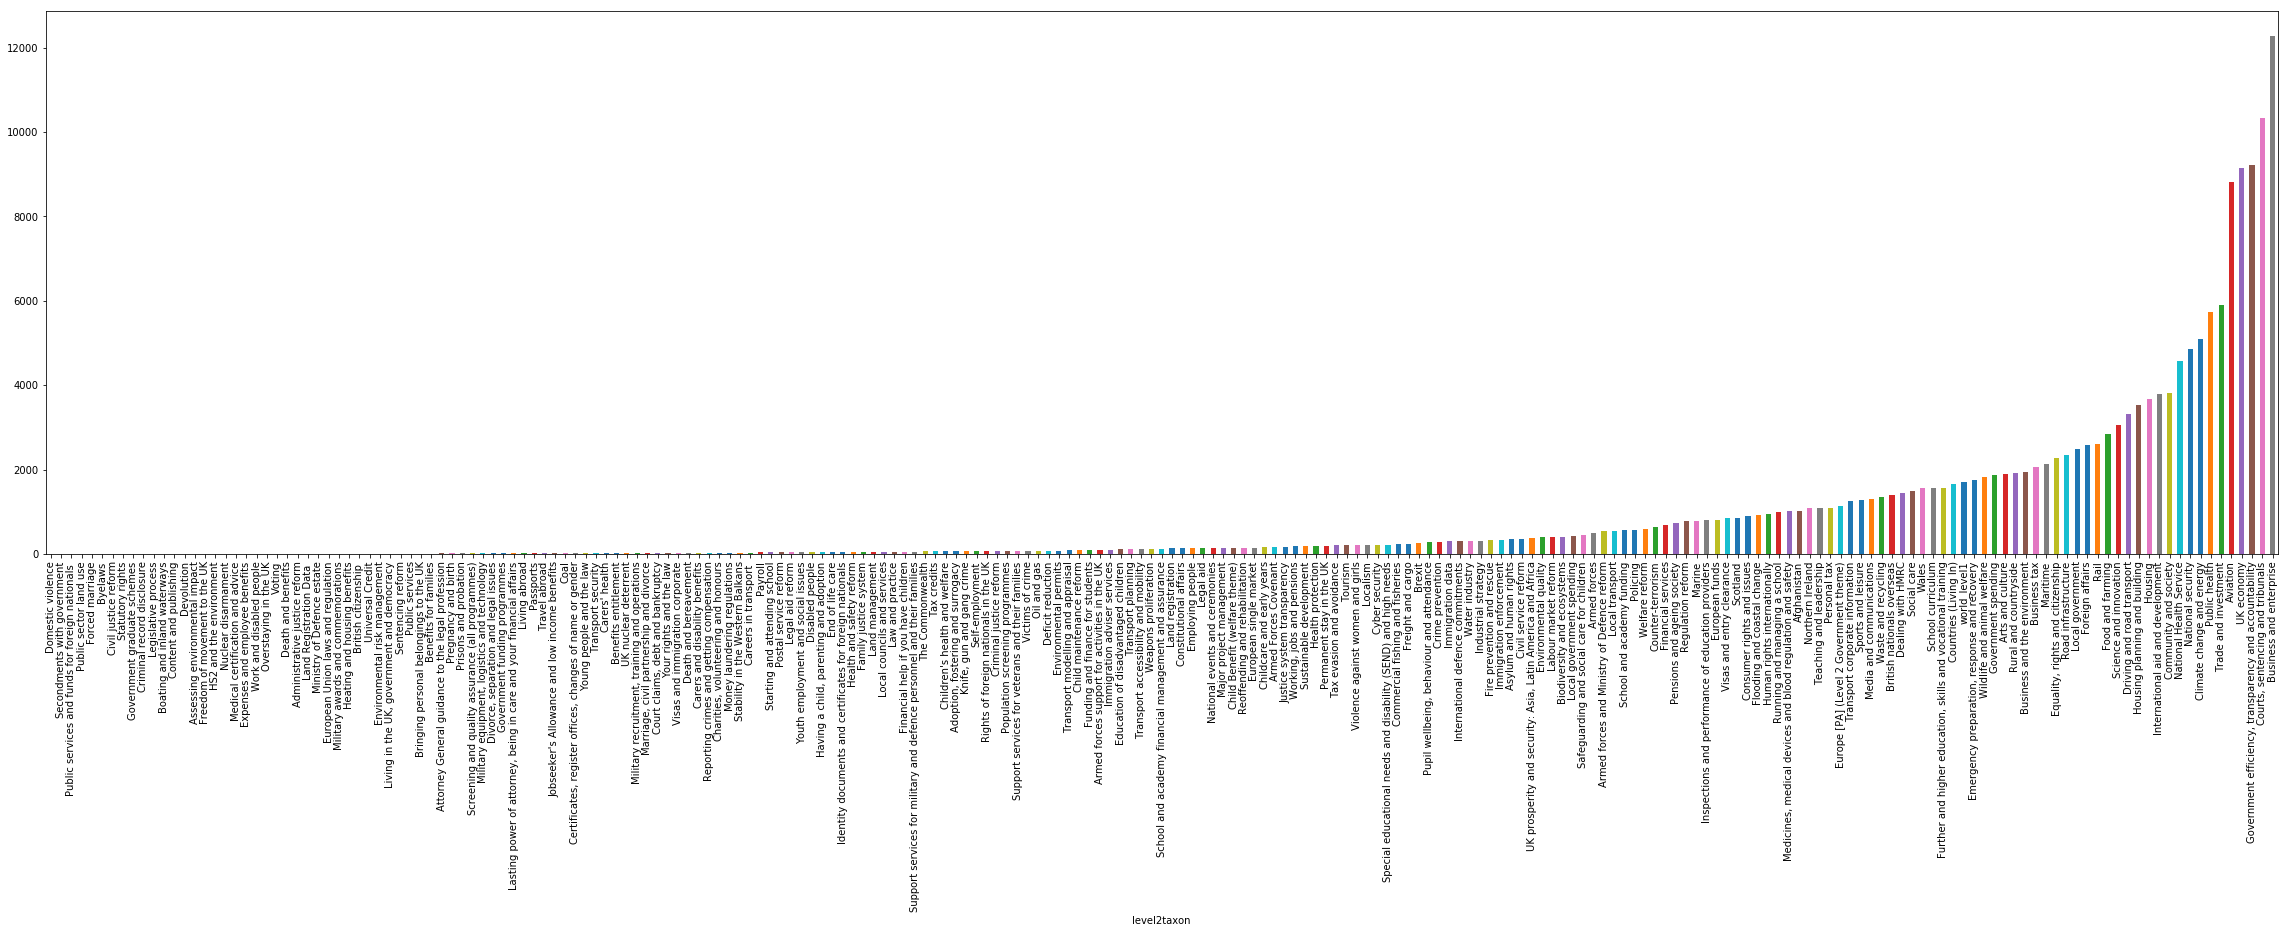

In [8]:
labelled_level2.groupby('level2taxon').size().sort_values(ascending=True).plot(kind = 'bar', figsize=(40,10))

### Load in data

In [9]:
true_train = pd.read_csv(os.path.join(DATADIR, 'true_train_1255_2103_.csv.gz'), dtype=float, compression='gzip')
pred_train = pd.read_csv(os.path.join(DATADIR, 'train_results_1255_2103_.csv.gz'), dtype=float, compression='gzip')

FileNotFoundError: [Errno 2] No such file or directory: '/data/2018-03-22/true_train_1255_2103_.csv.gz'

In [14]:
true_dev = pd.read_csv(os.path.join(DATADIR, 'true_dev_1226_2203_.csv.gz'), dtype=float, compression='gzip')
prob_dev = pd.read_csv(os.path.join(DATADIR, 'dev_results_1226_2203_.csv.gz'), dtype=float, compression='gzip')

In [ ]:
train = np.load(os.path.join(DATADIR, 'train_arrays.npz'))

In [15]:
dev = np.load(os.path.join(DATADIR, 'dev_arrays.npz'))

In [ ]:
train

In [ ]:
labelled_level2.loc[labelled_level2['content_id'].isin(train['content_id'])]

In [ ]:
train.files

In [ ]:
train['content_id']

In [ ]:
train['content_id'].shape

In [ ]:
true_train.shape[0]

### Evaluate model

#### Training metrics

In [ ]:
y_pred = pred_train.copy()

In [ ]:
y_pred[y_pred>=P_THRESHOLD] = 1
y_pred[y_pred<P_THRESHOLD] = 0

In [ ]:
print('micro: {}'.format(precision_recall_fscore_support(true_train, y_pred, average='micro', sample_weight=None)))
print('macro: {}'.format(precision_recall_fscore_support(true_train, y_pred, average='macro', sample_weight=None)))
print('weightedmacro: {}'.format(precision_recall_fscore_support(true_train, y_pred, average='weighted', sample_weight=None)))

In [ ]:
eval_metrics = precision_recall_fscore_support(true_train, y_pred, average=None, sample_weight=None)
eval_metrics_df = pd.DataFrame(list(eval_metrics))

In [ ]:
train_metrics = eval_metrics_df.transpose()
train_metrics.columns = ['precision', 'recall', 'f1', 'support']
train_metrics['level2code'] = train_metrics.index +1
train_metrics['level2label'] = train_metrics['level2code'].map(labels_index)

In [ ]:
train_metrics.head()

In [ ]:
train_metrics.sort_values('support', ascending=False).plot(x='level2label', y='support', kind = 'bar', figsize=(35,10), legend=False)

#### Development set metrics

In [16]:
pred_dev = prob_dev.copy()

In [17]:
pred_dev[pred_dev>=P_THRESHOLD] = 1
pred_dev[pred_dev<P_THRESHOLD] = 0

In [18]:
print('micro: {}'.format(precision_recall_fscore_support(true_dev, pred_dev, average='micro', sample_weight=None)))
print('macro: {}'.format(precision_recall_fscore_support(true_dev, pred_dev, average='macro', sample_weight=None)))
print('weightedmacro: {}'.format(precision_recall_fscore_support(true_dev, pred_dev, average='weighted', sample_weight=None)))

micro: (0.84424717546691264, 0.81516112873601598, 0.82944924253150221, None)
macro: (0.76120767687062862, 0.81163101605414345, 0.77781893358457876, None)
weightedmacro: (0.8481166647481343, 0.81516112873601598, 0.82882896784708981, None)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [19]:
eval_metrics = precision_recall_fscore_support(true_dev, pred_dev, average=None, sample_weight=None)
eval_metrics_df = pd.DataFrame(list(eval_metrics))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [20]:
dev_metrics = eval_metrics_df.transpose()
dev_metrics.columns = ['precision', 'recall', 'f1', 'support']
dev_metrics['taxon2code'] = dev_metrics.index +1
dev_metrics['taxon2label'] = dev_metrics['taxon2code'].map(labels_index)

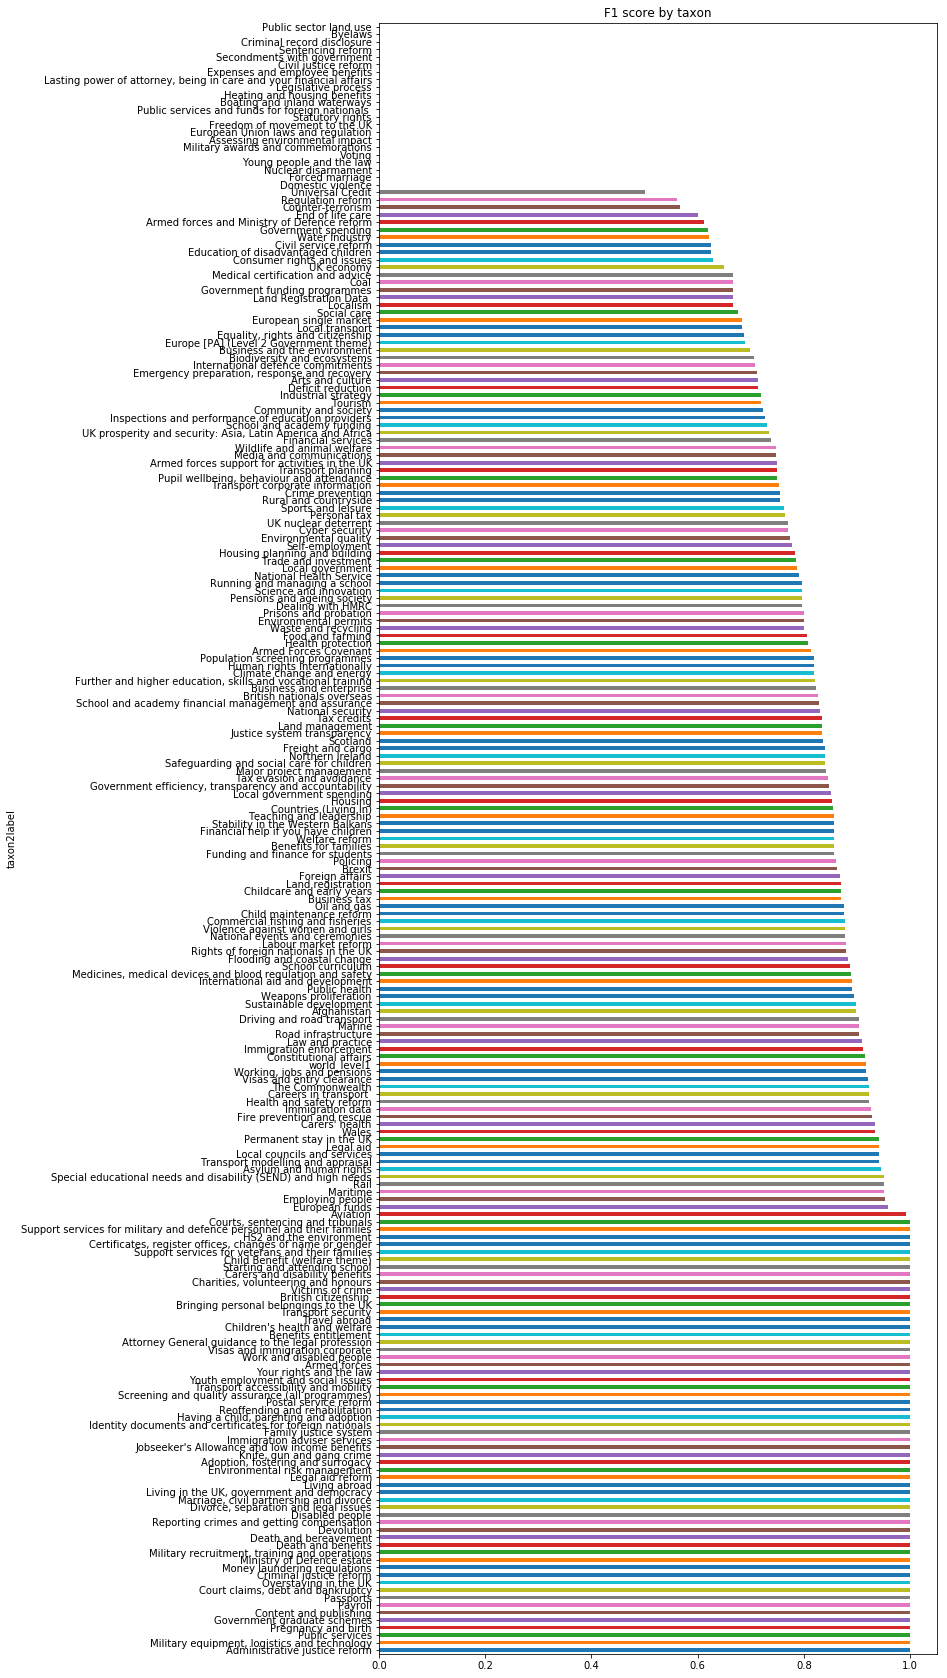

In [41]:
dev_metrics.sort_values('f1', ascending=False).plot(x='taxon2label', y='f1', kind = 'barh', figsize=(10,30), legend=False, title='F1 score by taxon')

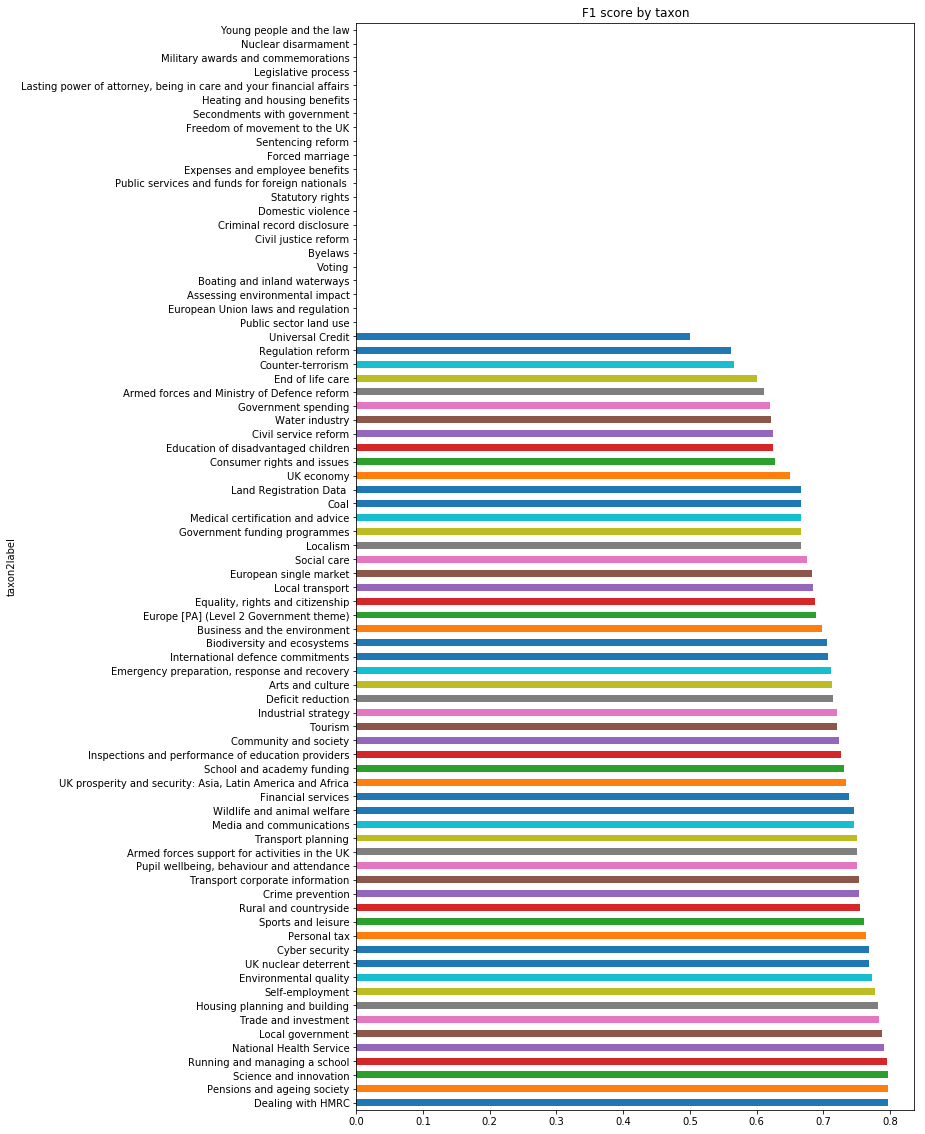

In [43]:
dev_metrics[dev_metrics['f1']<0.8].sort_values('f1', ascending=False).plot(x='taxon2label', y='f1', kind = 'barh', figsize=(10,20), legend=False, title='F1 score by taxon')

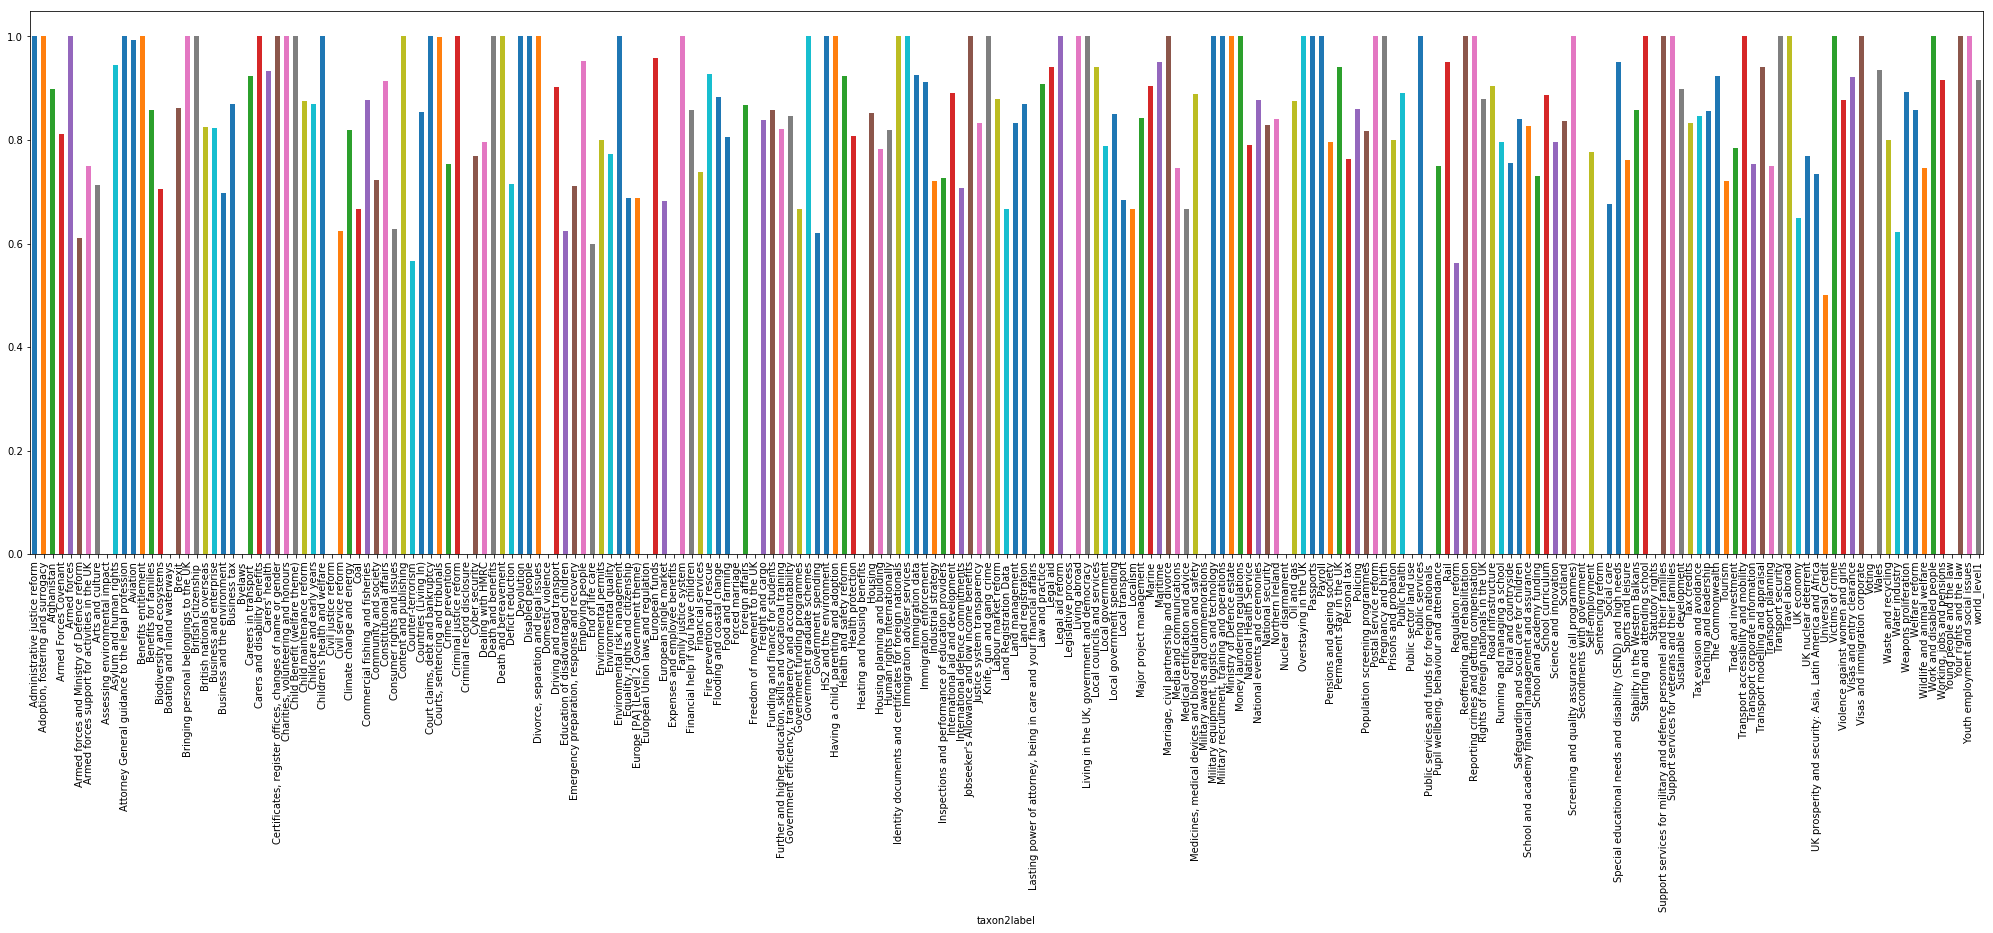

In [22]:
dev_metrics.sort_values('taxon2label', ascending=True).plot(x='taxon2label', y='f1', kind = 'bar', figsize=(35,10), legend=False)

In [23]:
dev_metrics[dev_metrics['f1']==0].shape[0]

25

In [24]:
dev_metrics[dev_metrics['f1']==1].shape[0]

57

In [25]:
dev_metrics[dev_metrics['f1']==1]

,precision,recall,f1,support,taxon2code,taxon2label
0,1.0,1.0,1.0,2.0,1,Administrative justice reform
1,1.0,1.0,1.0,6.0,2,"Adoption, fostering and surrogacy"
4,1.0,1.0,1.0,72.0,5,Armed forces
10,1.0,1.0,1.0,1.0,11,Attorney General guidance to the legal profession
12,1.0,1.0,1.0,2.0,13,Benefits for families
17,1.0,1.0,1.0,1.0,17,British citizenship
18,1.0,1.0,1.0,1.0,19,British citizenship
25,1.0,1.0,1.0,3.0,26,"Certificates, register offices, changes of nam..."
42,1.0,1.0,1.0,4.0,28,"Certificates, register offices, changes of nam..."
45,1.0,1.0,1.0,6.0,46,Criminal justice reform


In [26]:
dev_metrics.to_csv(os.path.join(DATADIR, "dev_metrics.csv.gz"), compression='gzip',index=False)

In [27]:
high = dev_metrics[dev_metrics['f1']>0.9]

In [28]:
morethan80 = dev_metrics[dev_metrics['f1']>0.8]

In [29]:
dev_metrics[dev_metrics['f1']<0.6].shape[0]

25

In [30]:
dev_metrics[dev_metrics['f1']<0.8].shape

(78, 6)

In [31]:
dev_metrics[dev_metrics['f1']==0].shape

(22, 6)

In [32]:
dev_metrics[dev_metrics['taxon2label']=='UK economy']

,precision,recall,f1,support,taxon2code,taxon2label
196,0.624365,0.67806,0.650106,907.0,197,UK economy


## support and performance

The support is the number of occurrences of each class in y_true

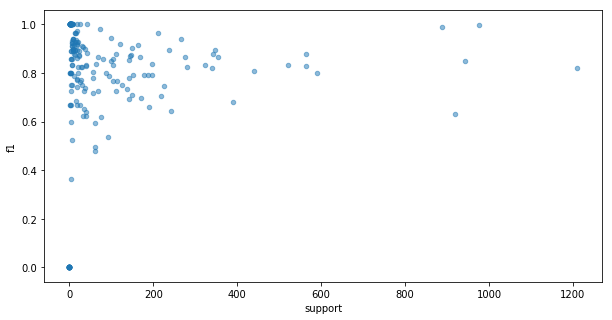

In [40]:
dev_metrics.plot.scatter(x='support', y='f1', marker='o', alpha=.5, figsize=(10, 5))


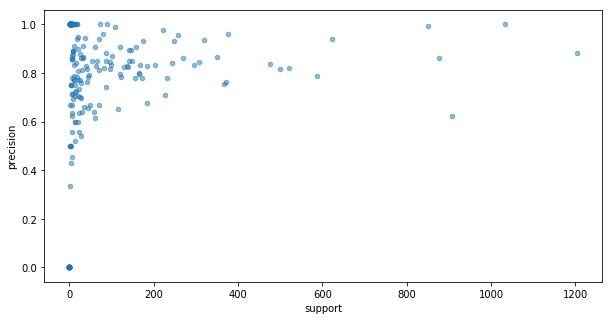

In [28]:
dev_metrics.plot.scatter(x='support', y='precision', marker='o', alpha=.5, figsize=(10, 5))


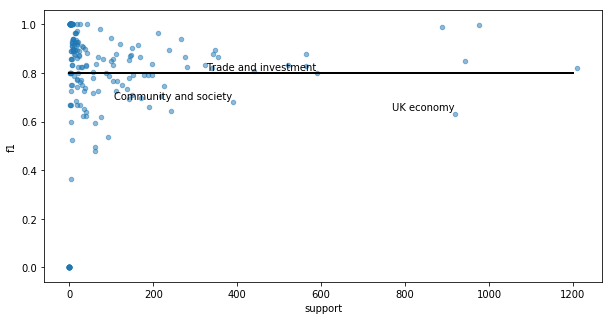

In [41]:
dev_metrics.plot.scatter(x='support', y='f1', marker='o', alpha=.5, figsize=(10, 5))
plt.plot([0, 1200],[0.8, 0.8],  'k-', lw=2)

for label, x, y in zip(dev_metrics['taxon2label'], dev_metrics['support'], dev_metrics['f1']):
    if (x>300 and y<0.8):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-1, 1),
            textcoords='offset points', ha='right', va='bottom')
    if (y==1):
        label = ""
        plt.annotate(
            label,
            xy=(x, y), xytext=(-1, 1),
            textcoords='offset points', ha='right', va='bottom')
        
plt.show()

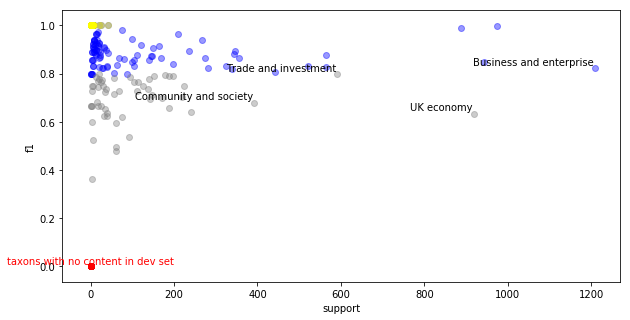

In [43]:
# normal values
plt.figure(figsize=(10, 5))
plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
         verticalalignment='bottom')
plt.xlabel('support')
plt.ylabel('f1')
plt.scatter(dev_metrics['support'][dev_metrics['f1']>=0.8], 
            dev_metrics['f1'][dev_metrics['f1']>=0.8], 
            c = 'b', 
            alpha=.4)
# less than 0.8
plt.scatter(dev_metrics['support'][dev_metrics['f1']<0.8], 
            dev_metrics['f1'][dev_metrics['f1']<0.8], 
            c = 'grey', 
            alpha=.4)

plt.scatter(dev_metrics['support'][dev_metrics['f1']==0], 
            dev_metrics['f1'][dev_metrics['f1']==0], 
            c = 'red', 
            alpha=.4)
plt.scatter(dev_metrics['support'][dev_metrics['f1']==1], 
            dev_metrics['f1'][dev_metrics['f1']==1], 
            c = 'yellow', 
            alpha=.4)


for label, x, y in zip(dev_metrics['taxon2label'], dev_metrics['support'], dev_metrics['f1']):
    if ((x>300 and y<0.8) or (x>1000)):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-1, 1),
            textcoords='offset points', ha='right', va='bottom')
    if (y==1):
        label = ""
        plt.annotate(
            label,
            xy=(x, y), xytext=(-1, 1),
            textcoords='offset points', ha='right', va='bottom')


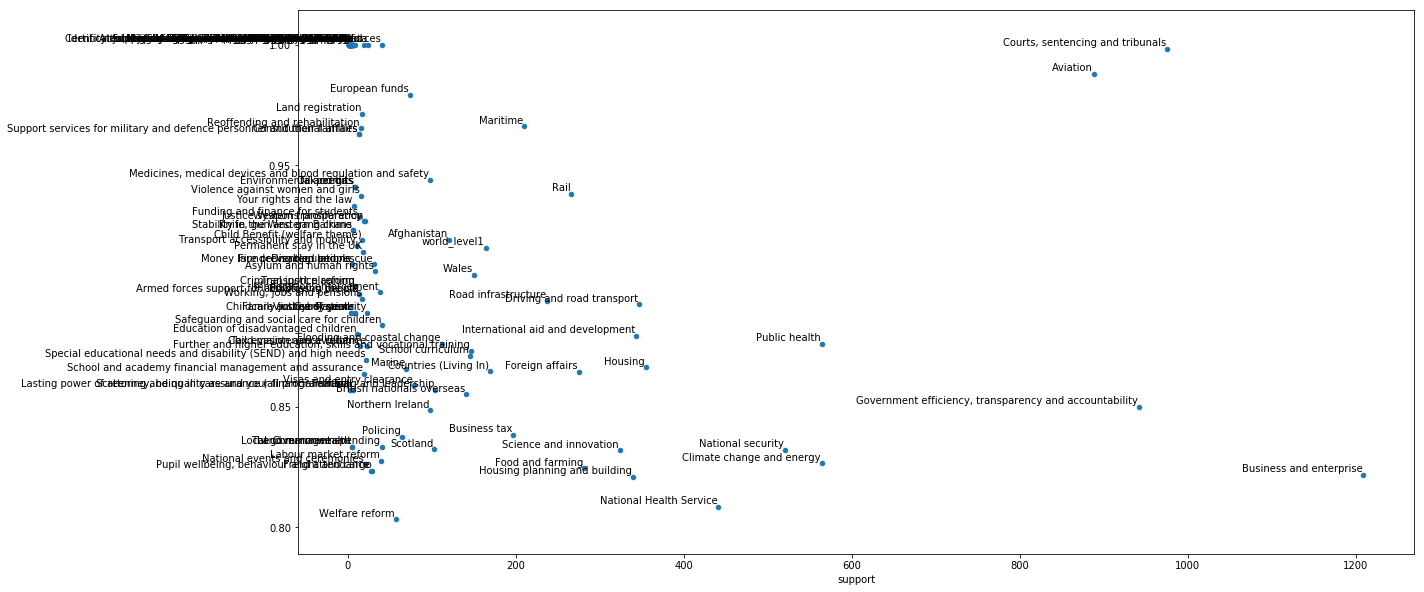

In [44]:
morethan80.plot.scatter(x='support', y='f1', figsize=(20, 10))

for label, x, y in zip(morethan80['taxon2label'], morethan80['support'], morethan80['f1']):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-1, 1),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

### look at content predicted in taxons with f1=1

In [45]:
prob_dev.head()

,1,2,3,4,5,6,7,8,9,10,...,208,209,210,211,212,213,214,215,216,217
0,1.430879e-09,3.309768e-08,4.247052e-13,8.958880e-13,1.298320e-10,3.362877e-12,1.229251e-12,6.832324e-08,2.213320e-10,1.292042e-11,...,3.082676e-07,9.380426e-14,1.452233e-07,2.354326e-11,4.151500e-11,5.813562e-10,7.937041e-12,2.377054e-11,4.236804e-12,1.841895e-09
1,3.113968e-13,3.778706e-12,7.884918e-17,9.256854e-16,8.363572e-16,1.481720e-11,1.824040e-17,3.851755e-17,3.049423e-11,7.666534e-16,...,2.005971e-09,1.607120e-11,9.737212e-12,1.821037e-13,2.061460e-13,1.941882e-16,3.676411e-15,8.298838e-15,1.369991e-15,4.240184e-15
2,2.116866e-08,2.228589e-08,1.819893e-08,1.151717e-08,5.583671e-08,2.767320e-06,3.104766e-07,5.035183e-05,4.062409e-07,4.108228e-05,...,5.028557e-07,4.117422e-09,2.279215e-08,6.398191e-06,1.281500e-08,8.433078e-08,3.270990e-08,4.669498e-07,5.013872e-09,1.333951e-11
3,3.340944e-22,1.473327e-24,0.000000e+00,0.000000e+00,2.092249e-29,0.000000e+00,0.000000e+00,1.243686e-35,4.582615e-23,9.274240e-24,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.962431e-28,3.588763e-18,0.000000e+00,1.783602e-14,6.085796e-38,5.465818e-36
4,3.831374e-15,4.467982e-15,2.698618e-09,1.396589e-07,5.983008e-11,3.146719e-01,5.949466e-09,1.307382e-10,5.920678e-13,4.522938e-17,...,1.468630e-13,3.077830e-07,1.313327e-16,4.691339e-07,2.959625e-10,9.617959e-11,1.781978e-16,4.001303e-14,3.831268e-13,4.190362e-11


In [46]:
dev_metrics[dev_metrics['f1']==1].head()

precision  recall   f1  support  taxon2code  \
0         1.0     1.0  1.0      1.0           1   
1         1.0     1.0  1.0      5.0           2   
4         1.0     1.0  1.0     41.0           5   
10        1.0     1.0  1.0      2.0          11   
13        1.0     1.0  1.0      2.0          14   

                                          taxon2label  
0                       Administrative justice reform  
1                   Adoption, fostering and surrogacy  
4                                        Armed forces  
10  Attorney General guidance to the legal profession  
13                              Benefits for families

In [47]:
perfect_performance = dev_metrics[dev_metrics['f1']==1].taxon2code.unique()
perfect_performance = perfect_performance.astype(str)

In [48]:
keep_perfect_performing_taxons = prob_dev[perfect_performance].copy()

In [49]:
keep_perfect_performing_taxons.shape

(12913, 52)

In [50]:
if dev['content_id'].shape[0] == keep_perfect_performing_taxons.shape[0]:
    keep_perfect_performing_taxons['content_id'] = dev['content_id']
else:
    print("warning: true_train and content_id may not originate from same data")

In [51]:
keep_perfect_performing_taxons.head()

,1,2,5,11,14,18,19,25,26,28,...,180,183,193,195,196,198,204,212,214,content_id
0,1.430879e-09,3.309768e-08,1.298320e-10,3.939044e-10,5.227610e-10,1.410472e-13,1.047163e-09,3.371334e-06,3.086370e-10,4.191875e-10,...,1.727348e-10,5.718464e-11,5.349153e-06,1.834596e-08,3.209234e-12,1.001914e-14,3.446411e-11,4.151500e-11,7.937041e-12,6c067b7b-bbb4-4fa3-99eb-9208ee107cf2
1,3.113968e-13,3.778706e-12,8.363572e-16,2.981054e-16,4.828721e-14,4.186480e-11,6.013720e-17,6.605078e-18,3.627237e-15,2.784229e-16,...,3.650902e-17,1.440933e-16,2.915856e-16,2.620753e-17,1.895805e-17,6.273218e-13,2.003007e-13,2.061460e-13,3.676411e-15,5d294f46-7631-11e4-a3cb-005056011aef
2,2.116866e-08,2.228589e-08,5.583671e-08,5.463477e-07,3.536001e-08,3.227854e-08,1.469474e-08,8.539615e-08,8.942073e-11,5.715059e-07,...,1.682923e-09,2.672911e-10,2.909654e-06,2.030872e-06,1.809316e-11,1.274726e-11,3.845818e-08,1.281500e-08,3.270990e-08,5c77bca0-7631-11e4-a3cb-005056011aef
3,3.340944e-22,1.473327e-24,2.092249e-29,1.678694e-24,6.163769e-28,0.000000e+00,0.000000e+00,0.000000e+00,3.858609e-24,9.482443e-32,...,4.105049e-27,1.220818e-36,5.523804e-18,0.000000e+00,5.478295e-38,2.548888e-31,5.220391e-23,1.962431e-28,0.000000e+00,dfd6dc72-4fe4-4d59-a59c-337117cd52c9
4,3.831374e-15,4.467982e-15,5.983008e-11,6.168891e-15,1.981987e-17,1.340832e-13,7.477240e-15,5.120082e-16,1.729434e-15,3.694412e-12,...,4.684097e-17,1.287080e-09,2.166474e-13,3.486345e-11,2.128840e-11,2.163071e-10,2.881984e-12,2.959625e-10,1.781978e-16,a951a1c0-fa23-4edc-b229-1b93ce6dc55c


In [52]:
# armed forces

keep_perfect_performing_taxons[keep_perfect_performing_taxons['5'] > 0.5].shape

(41, 53)

In [53]:
perfect_by_id = pd.melt(keep_perfect_performing_taxons, 
                        id_vars=['content_id'], var_name='taxon2', value_name='prob')

In [54]:
perfect_by_id.shape

(671476, 3)

In [55]:
positive_perfect = perfect_by_id[perfect_by_id['prob']>0.5].copy()

In [56]:
positive_perfect.shape

(223, 3)

In [57]:
positive_perfect_meta = pd.merge(
    left=positive_perfect,
    right=labelled_level2,
    on='content_id',
    how='left',
    indicator=True, 
    validate='m:m'
)

In [58]:
positive_perfect_meta['taxon2label'] = pd.to_numeric(positive_perfect_meta['taxon2']).map(labels_index)

In [59]:
positive_perfect_meta

,content_id,taxon2,prob,base_path,content_purpose_document_supertype,content_purpose_subgroup,content_purpose_supergroup,description,details,document_type,...,taxon_base_path,taxon_name,level1taxon,level2taxon,level3taxon,level4taxon,level5taxon,level2taxon_code,_merge,taxon2label
0,714b7c4c-269a-40fd-b3d8-41eda3d5517a,1,0.999967,/government/consultations/merger-of-local-just...,engagement-activities,consultations,policy_and_engagement,seeks views on merging 8 local justice areas (...,"{'body': '<div class=""govspeak""><p>There are 3...",closed_consultation,...,/crime-justice-and-law/administrative-justice-...,Administrative justice reform,"Crime, justice and law",Administrative justice reform,NaN,NaN,NaN,1,both,Administrative justice reform
1,5efadaec-7631-11e4-a3cb-005056011aef,2,0.999984,/government/publications/children-act-1989-pri...,guidance,regulation,guidance_and_regulation,statutory guidance for local authorities on sa...,"{'body': '<div class=""govspeak""><p>This statut...",statutory_guidance,...,/childcare-parenting/fostering,Fostering,"Parenting, childcare and children's services","Adoption, fostering and surrogacy",Fostering,NaN,NaN,2,both,"Adoption, fostering and surrogacy"
2,6cc57294-2821-4c49-bd7a-0a960089626d,2,0.999998,/become-a-childs-legal-parent,guidance,guidance,guidance_and_regulation,get a parental order to become a child's legal...,{'body': '<p>You’ll need to apply for a parent...,answer,...,/childcare-parenting/adoption,Adoption,"Parenting, childcare and children's services","Adoption, fostering and surrogacy",Adoption,NaN,NaN,2,both,"Adoption, fostering and surrogacy"
3,6cc57294-2821-4c49-bd7a-0a960089626d,2,0.999998,/become-a-childs-legal-parent,guidance,guidance,guidance_and_regulation,get a parental order to become a child's legal...,{'body': '<p>You’ll need to apply for a parent...,answer,...,/life-circumstances/child-adoption,"Having a child, parenting and adoption",Life circumstances,"Having a child, parenting and adoption",NaN,NaN,NaN,90,both,"Adoption, fostering and surrogacy"
4,9fbb617d-869a-4a4b-b781-c80b296062c7,2,0.999985,/guidance/social-care-common-inspection-framew...,guidance,guidance,guidance_and_regulation,guidance about how independent fostering agenc...,{'body': '<p>The SCCIF is for use from April 2...,manual,...,/childcare-parenting/fostering,Fostering,"Parenting, childcare and children's services","Adoption, fostering and surrogacy",Fostering,NaN,NaN,2,both,"Adoption, fostering and surrogacy"
5,9fbb617d-869a-4a4b-b781-c80b296062c7,2,0.999985,/guidance/social-care-common-inspection-framew...,guidance,guidance,guidance_and_regulation,guidance about how independent fostering agenc...,{'body': '<p>The SCCIF is for use from April 2...,manual,...,/childcare-parenting/inspections-fostering-ado...,Inspections of fostering and adoption agencies,"Parenting, childcare and children's services",Safeguarding and social care for children,Children's social care providers,Inspection of children's social care providers,Inspections of fostering and adoption agencies,166,both,"Adoption, fostering and surrogacy"
6,5efc231b-7631-11e4-a3cb-005056011aef,2,0.999999,/government/publications/fostering-services-as...,guidance,regulation,guidance_and_regulation,statutory guidance for local authorities on th...,"{'body': '<div class=""govspeak""><p>This guidan...",statutory_guidance,...,/childcare-parenting/fostering,Fostering,"Parenting, childcare and children's services","Adoption, fostering and surrogacy",Fostering,NaN,NaN,2,both,"Adoption, fostering and surrogacy"
7,5e385e06-7631-11e4-a3cb-005056011aef,2,0.999918,/government/statistics/notifications-of-privat...,data,research_and_data,transparency,the number of notifications of private fosteri...,"{'body': '<div class=""govspeak""><p>Figures on ...",national_statistics,...,/childcare-parenting/fostering,Fostering,"Parenting, childcare and children's services","Adoption, fostering and surrogacy",Fostering,NaN,NaN,2,both,"Adoption, fostering and surrogacy

In [60]:
print("{}% of content has been tagged to taxons which have perfect performance".format(
    positive_perfect.content_id.nunique()/keep_perfect_performing_taxons.shape[0]*100)
)

1.5952915666382714% of content has been tagged to taxons which have perfect performance


quick browse but this looks good

###  80 < taxon F1 <1 = good performance!

In [61]:
good_performance = dev_metrics[(dev_metrics['f1']<1) & (dev_metrics['f1']>0.8)].taxon2code.unique().astype(str)

In [62]:
keep_good_performing_taxons = prob_dev[good_performance].copy()

In [63]:
keep_good_performing_taxons.shape

(12913, 84)

In [64]:
if dev['content_id'].shape[0] == keep_good_performing_taxons.shape[0]:
    keep_good_performing_taxons['content_id'] = dev['content_id']
else:
    print("warning: true_train and content_id may not originate from same data")

In [65]:
good_by_id = pd.melt(keep_good_performing_taxons, 
                        id_vars=['content_id'], var_name='taxon2', value_name='prob')

In [66]:
good_by_id.shape

(1084692, 3)

In [67]:
positive_good = good_by_id[good_by_id['prob']>0.5].copy()

In [68]:
positive_good.shape

(11533, 3)

In [69]:
positive_good.content_id.nunique()

9972

In [70]:
print("{}% of content has been tagged to taxons which have good performance".format(
    positive_good.content_id.nunique()/keep_good_performing_taxons.shape[0]*100)
)

77.22450243940216% of content has been tagged to taxons which have good performance


In [71]:
positive_good_meta = pd.merge(
    left=positive_good,
    right=labelled_level2,
    on='content_id',
    how='left',
    indicator=True, 
    validate='m:m'
)

In [72]:
positive_good_meta['taxon2label'] = pd.to_numeric(positive_good_meta['taxon2']).map(labels_index)

In [73]:
positive_good_meta

,content_id,taxon2,prob,base_path,content_purpose_document_supertype,content_purpose_subgroup,content_purpose_supergroup,description,details,document_type,...,taxon_base_path,taxon_name,level1taxon,level2taxon,level3taxon,level4taxon,level5taxon,level2taxon_code,_merge,taxon2label
0,5c9342c5-7631-11e4-a3cb-005056011aef,3,0.977974,/government/news/the-life-of-an-army-doctor-on...,news,news,news_and_communications,being a doctor based at a patrol base in afgha...,"{'body': '<div class=""govspeak""><p>For Captain...",news_story,...,/government/national-security,National security,Government,National security,NaN,NaN,NaN,138,both,Afghanistan
1,5c9342c5-7631-11e4-a3cb-005056011aef,3,0.977974,/government/news/the-life-of-an-army-doctor-on...,news,news,news_and_communications,being a doctor based at a patrol base in afgha...,"{'body': '<div class=""govspeak""><p>For Captain...",news_story,...,/international/government-topics-foreign-affai...,Afghanistan,International,Foreign affairs,Afghanistan,NaN,NaN,80,both,Afghanistan
2,5c9342c5-7631-11e4-a3cb-005056011aef,3,0.977974,/government/news/the-life-of-an-army-doctor-on...,news,news,news_and_communications,being a doctor based at a patrol base in afgha...,"{'body': '<div class=""govspeak""><p>For Captain...",news_story,...,/defence/afghanistan,Afghanistan,Defence,Afghanistan,NaN,NaN,NaN,3,both,Afghanistan
3,5c94e285-7631-11e4-a3cb-005056011aef,3,0.994171,/government/news/new-zealand-renews-afghanista...,news,news,news_and_communications,defence secretary dr liam fox has welcomed the...,"{'body': '<div class=""govspeak""><p>The commitm...",news_story,...,/government/national-security,National security,Government,National security,NaN,NaN,NaN,138,both,Afghanistan
4,5c94e285-7631-11e4-a3cb-005056011aef,3,0.994171,/government/news/new-zealand-renews-afghanista...,news,news,news_and_communications,defence secretary dr liam fox has welcomed the...,"{'body': '<div class=""govspeak""><p>The commitm...",news_story,...,/international/government-topics-foreign-affai...,Afghanistan,International,Foreign affairs,Afghanistan,NaN,NaN,80,both,Afghanistan
5,5c94e285-7631-11e4-a3cb-005056011aef,3,0.994171,/government/news/new-zealand-renews-afghanista...,news,news,news_and_communications,defence secretary dr liam fox has welcomed the...,"{'body': '<div class=""govspeak""><p>The commitm...",news_story,...,/defence/afghanistan,Afghanistan,Defence,Afghanistan,NaN,NaN,NaN,3,both,Afghanistan
6,5c8848a9-7631-11e4-a3cb-005056011aef,3,0.999557,/government/news/deep-sadness-at-death-of-brit...,news,news,news_and_communications,foreign secretary william hague has released a...,"{'body': '<div class=""govspeak""><p>The Foreign...",news_story,...,/government/national-security,National security,Government,National security,NaN,NaN,NaN,138,both,Afghanistan
7,5c8848a9-7631-11e4-a3cb-005056011aef,3,0.999557,/government/news/deep-sadness-at-death-of-brit...,news,news,news_and_communications,foreign secretary william hague has released a...,"{'body': '<div class=""govspeak""><p>The Foreign...",news_story,...,/international/government-topics-foreign-affai...,Afghanistan,International,Foreign affairs,Afghanistan,NaN,NaN,80,both,Afghanistan
8,5c8848a9-7631-11e4-a3cb-005056011aef,3,0.999557,/government/news/deep-sadness-at-death-of-brit...,news,news,news_and_communications,foreign secretary william hague has released a...,"{'body': '<div class=""govspeak""><p>The Foreign...",news_story,...,/defence/afghanistan,Afghanistan,Defence,Afghanistan,NaN,NaN,NaN,3,both,Afghanistan
9,5d89d9ff-7631-11e4-a3cb-005056011aef,3,1.000000,/government/news/scots-guards-return-from-afgh...,news,news,news_and_communications,70 soldiers from the scots guards battle group...,"{'body': '<div class=""govspeak""><p>The soldier...",news_story,...,/government/national-security,National security,Government,National security,NaN,NaN,NaN,138,both,Afghanistan


### UK economy
We know from inspection of the predictions on the untagged data that things are going wrong for UK economy. Can we look at some examples?

In [ ]:
uk_econ_true = 

In [ ]:
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

In [74]:
if dev['content_id'].shape[0] == keep_perfect_performing_taxons.shape[0]:
    keep_perfect_performing_taxons['content_id'] = dev['content_id']
else:
    print("warning: true_train and content_id may not originate from same data")

In [73]:
no_auto_content['support'].sort_values().plot( kind = 'barh', figsize=(20, 20))

NameError: name 'no_auto_content' is not defined

In [75]:
f1_byclass = pd.DataFrame((a)[2], columns=['f1'])

support_byclass = pd.DataFrame((a)[3], columns=['support'])

f1_byclass = pd.merge(
    left=f1_byclass, 
    right=support_byclass, 
    left_index=True,
    right_index=True,
    how='outer', 
    validate='one_to_one'
)

f1_byclass['index_col'] = f1_byclass.index

f1_byclass['level2taxon'] = f1_byclass['index_col'].map(labels_index).copy()

print("At p_threshold of {}, there were {} out of {} ({})% taxons with auto-tagged content in the training data"
      .format(P_THRESHOLD, 
              f1_byclass.loc[f1_byclass['f1'] > 0].shape[0], 
              y_pred.shape[1], 
              (f1_byclass.loc[f1_byclass['f1'] > 0].shape[0]/y_pred.shape[1])*100 ))

NameError: name 'a' is not defined

In [ ]:
no_auto_content = f1_byclass.loc[f1_byclass['f1'] == 0]
no_auto_content = no_auto_content.set_index('level2taxon')

In [ ]:
classes_predictedto = f1_byclass.loc[f1_byclass['f1'] > 0]
classes_predictedto = classes_predictedto.set_index('level2taxon') 

In [ ]:
classes_predictedto.plot.scatter(x='support', y='f1', figsize=(20, 10), xticks=np.arange(0, 9700, 100))

In [ ]:
classes_predictedto['f1'].sort_values().plot( kind = 'barh', figsize=(20, 20))

In [ ]:
#Calculate globally by counting the total true positives, false negatives and false positives.
precision_recall_fscore_support(y_train, y_pred, average='micro', sample_weight=None) 

In [ ]:
#Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
precision_recall_fscore_support(y_train, y_pred, average='macro', sample_weight=None)

In [ ]:
#Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
precision_recall_fscore_support(y_train, y_pred, average='weighted', sample_weight=None)

In [ ]:
#Calculate globally by counting the total true positives, false negatives and false positives.
precision_recall_fscore_support(y_dev, y_pred_dev, average='micro', sample_weight=None) 

In [ ]:
#Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
precision_recall_fscore_support(y_dev, y_pred_dev, average='macro', sample_weight=None)

In [ ]:
#Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
precision_recall_fscore_support(y_dev, y_pred_dev, average='weighted', sample_weight=None)

## LOAD More data

In [ ]:
if train['content_id'].shape[0] == true_train.shape[0]:
    true_train['content_id'] = train['content_id']
else:
    print("warning: true_train and content_id may not originate from same data")

In [ ]:
if dev['content_id'].shape[0] == true_dev.shape[0]:
    true_dev['content_id'] = dev['content_id']
else:
    print("warning: true_dev and content_id may not originate from same data")

## Taxons not represented in training/dev

In [76]:
train_by_id = pd.melt(true_train, id_vars=['content_id'], var_name='taxon2', value_name='tagged')
positive_taxons_true_train = train_by_id[train_by_id['tagged']==1].copy()

KeyError: 'content_id'

In [ ]:
dev_by_id = pd.melt(true_dev, id_vars=['content_id'], var_name='taxon2', value_name='tagged')
positive_taxons_true_dev = dev_by_id[dev_by_id['tagged']==1].copy()

In [ ]:
positive_taxons_true_train['taxon2label'] = pd.to_numeric(positive_taxons_true_train['taxon2']).map(labels_index)
positive_taxons_true_dev['taxon2label'] = pd.to_numeric(positive_taxons_true_dev['taxon2']).map(labels_index)

In [ ]:
positive_taxons_true_train.taxon2.nunique()

In [ ]:
positive_taxons_true_dev.taxon2.nunique()

In [ ]:
positive_taxons_true_train.taxon2.nunique() - positive_taxons_true_dev.taxon2.nunique()

In [ ]:
not_in_dev = np.setdiff1d(positive_taxons_true_train.taxon2label, positive_taxons_true_dev.taxon2label)

np.setdiff1d(positive_taxons_true_train.taxon2label, positive_taxons_true_dev.taxon2label)

In [ ]:
positive_taxons_true_train[positive_taxons_true_train['taxon2label'].isin(not_in_dev)].groupby('taxon2label').size().sort_values(ascending=False)

In [ ]:
true_train = true_train.drop_duplicates(subset='content_id')

In [ ]:
train_true = pd.merge(
    left=true_train,
    right=labelled_level2,
    on='content_id',
    how='left',
    indicator=True, 
    validate='1:m'
)

In [ ]:
true_train.shape

In [ ]:
train_true.groupby('_merge').size().sort_values(ascending=True)

In [ ]:
train_true.shape

In [ ]:
train_true.level2taxon.nunique()

In [ ]:
labelled_level2.level2taxon.nunique()

In [ ]:
pred_dev.shape

In [ ]:
print(actual_train.shape)
actual_train.head()

In [ ]:
print(pred_train.shape)
pred_train.head()

In [ ]:
true_train.shape

In [ ]:
pred_train.shape

### Produce some dummy results for testing.

In [ ]:
array = np.random.randint(2,size=(100000,420))

In [ ]:
df = pd.DataFrame(data=array.tolist(),columns=[i for i in range(1,421)])

In [ ]:
df.head()

In [ ]:
df.to_csv(os.path.join(DATADIR, 'dummy_results.csv.gz'),compression='gzip',index=False)